In [1]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import datetime

In [2]:
import time

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from pandas import get_dummies


/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [96]:
train = pd.read_csv('dataset/all/input/train.csv')

In [2]:
test = pd.read_csv('dataset/all/input/test.csv')

In [3]:
test.shape

(123623, 5)

In [98]:
data_dict = pd.read_excel('dataset/all/input/Data_Dictionary.xlsx',sheet_name = 'train')
data_dict

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [99]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [101]:
train.shape

(201917, 6)

In [102]:
train.describe()

,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636
std,1.186160,0.751362,0.495683,3.850500
min,1.000000,1.000000,0.000000,-33.219281
25%,2.000000,1.000000,0.000000,-0.883110
50%,3.000000,2.000000,1.000000,-0.023437
75%,4.000000,2.000000,1.000000,0.765453
max,5.000000,3.000000,1.000000,17.965068


In [103]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [105]:
train = train.dropna()
train.shape

(201917, 6)

In [106]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target'],
      dtype='object')

In [109]:
np.unique(train['target'].values)

array([-33.21928095, -17.60814651, -17.49263951, ...,  15.99445509,
        17.67571588,  17.9650684 ])

In [110]:
train.where(train['target'] == 1).count()

first_active_month    117
card_id               117
feature_1             117
feature_2             117
feature_3             117
target                117
dtype: int64

In [111]:
train[train['target'] < -32].count()

first_active_month    2207
card_id               2207
feature_1             2207
feature_2             2207
feature_3             2207
target                2207
dtype: int64

In [113]:
train.feature_1.unique()

array([1, 0])

In [114]:
train.feature_2.unique()

array([2, 1, 3])

In [115]:
train.feature_3.unique()

array([1, 0])

# Data Visualization

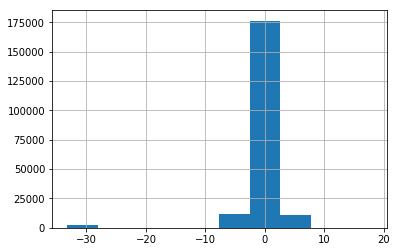

In [116]:
train["target"].hist()

<Figure size 432x288 with 0 Axes>

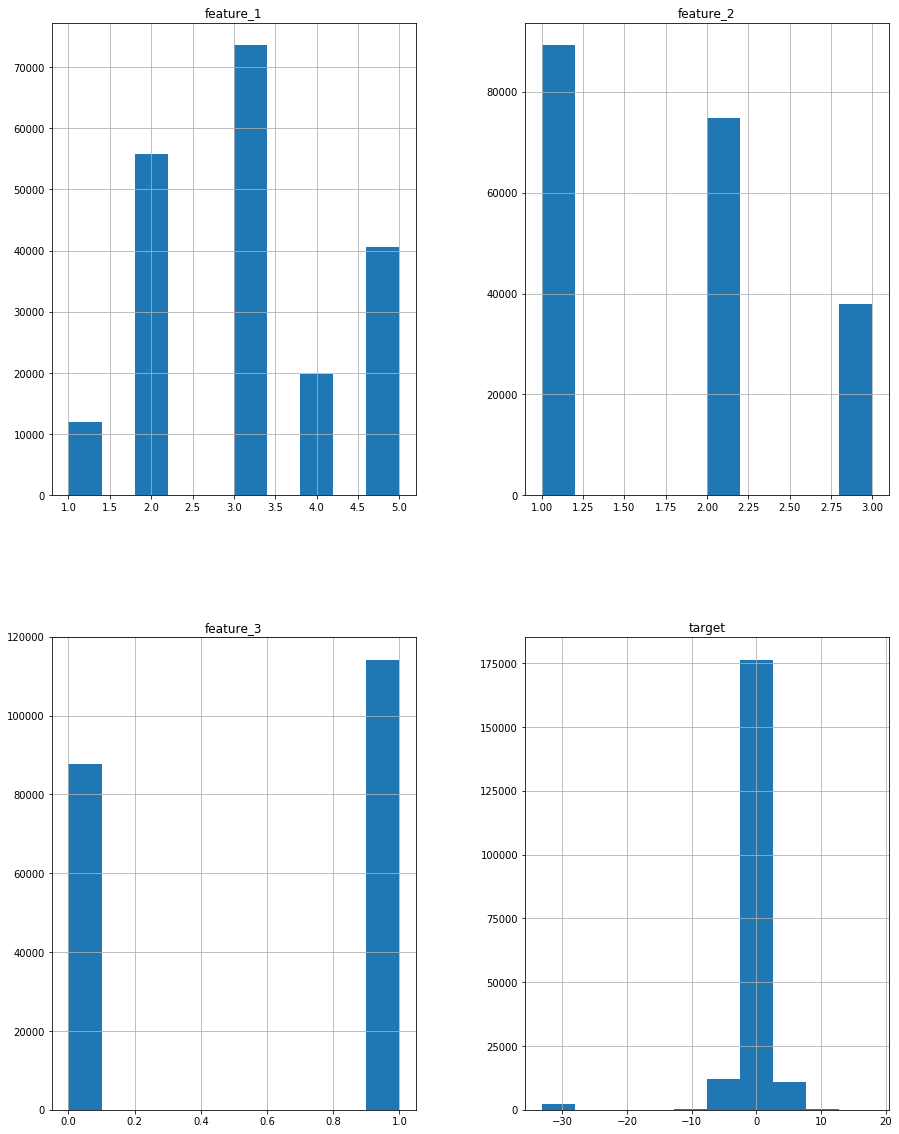

<Figure size 432x288 with 0 Axes>

In [118]:
train.hist(figsize = (15,20))
plt.figure()

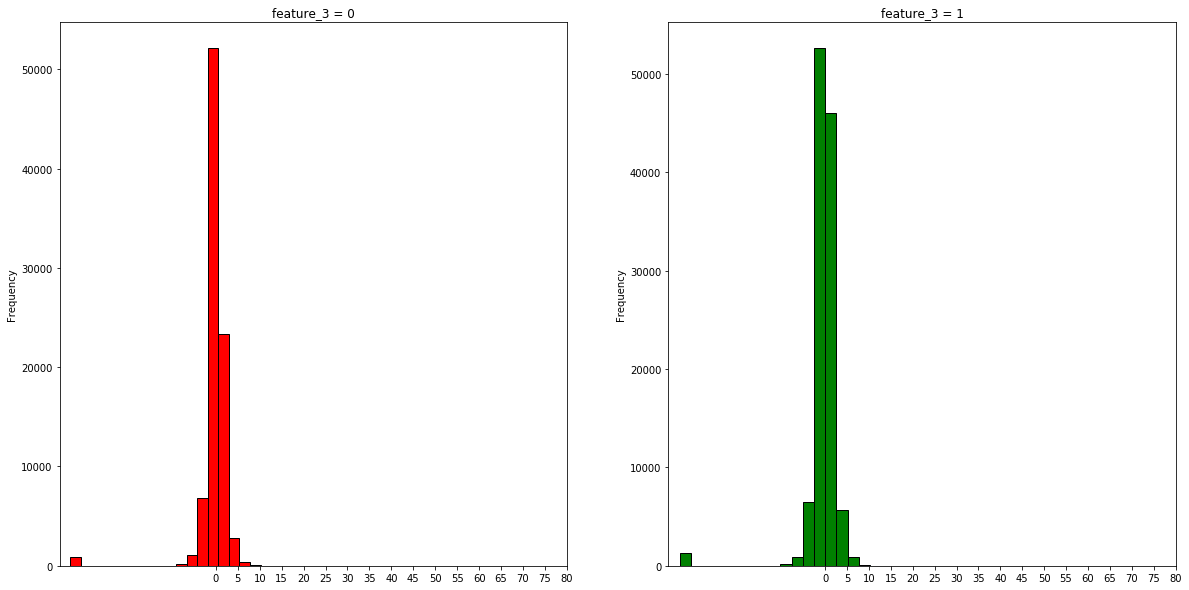

In [119]:
f,ax = plt.subplots(1,2,figsize = (20,10))
train[train['feature_3'] == 0].target.plot.hist(ax = ax[0], color = 'red', bins = 20, edgecolor = 'black')
ax[0].set_title('feature_3 = 0')
x1 = list(range(0,85,5))
ax[0].set_xticks(x1)
train[train['feature_3'] == 1].target.plot.hist(ax = ax[1], color = 'green', bins = 20, edgecolor = 'black')
ax[1].set_title('feature_3 = 1')
x2 = list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

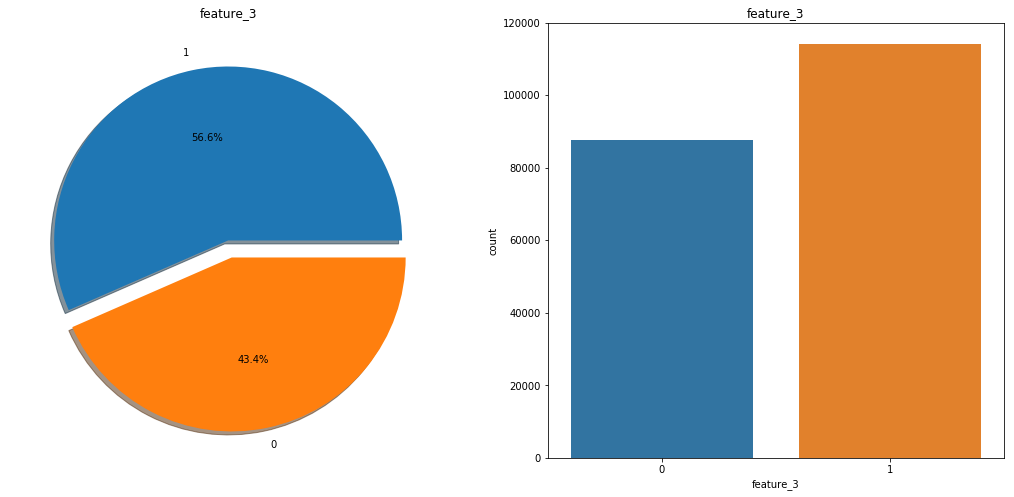

In [120]:
f,ax = plt.subplots(1,2,figsize = (18,8))
train['feature_3'].value_counts().plot.pie(explode = [0,0.1], autopct = '%1.1f%%', ax = ax[0], shadow = True)
ax[0].set_title('feature_3')
ax[0].set_ylabel('')
sns.countplot('feature_3',data = train, ax = ax[1])
ax[1].set_title('feature_3')
plt.show()

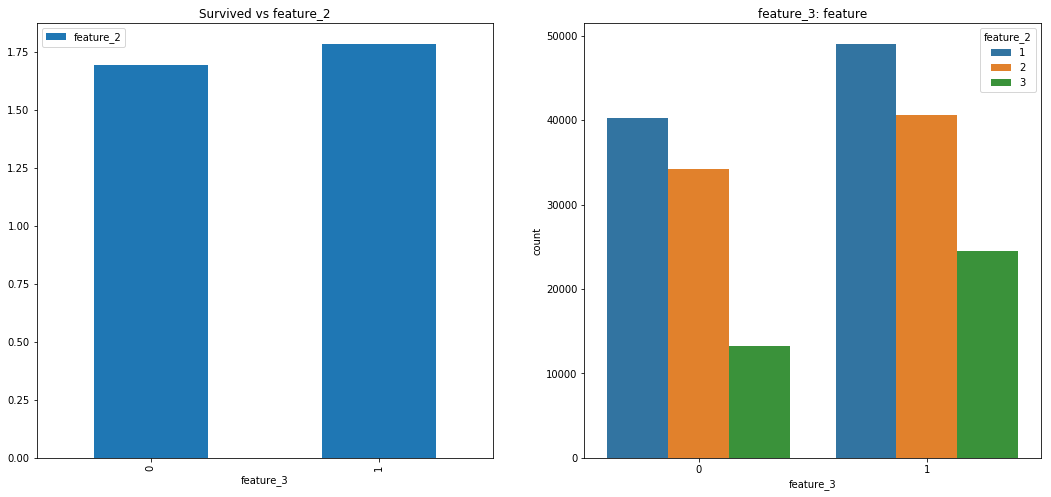

In [121]:
f,ax = plt.subplots(1,2,figsize = (18,8))
train[['feature_3','feature_2']].groupby(['feature_3']).mean().plot.bar(ax = ax[0])
ax[0].set_title('Survived vs feature_2')
sns.countplot('feature_3', hue = 'feature_2', data = train, ax = ax[1])
ax[1].set_title('feature_3: feature')
plt.show()

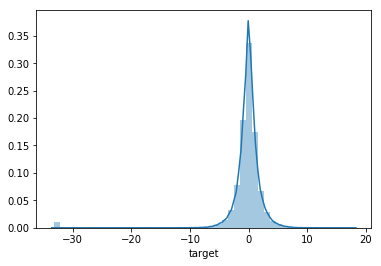

In [122]:
#distplot
sns.distplot(train['target'])

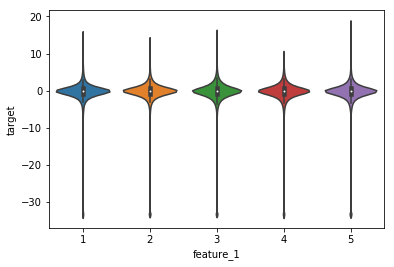

In [123]:
#violinplot
sns.violinplot(data = train, x = 
              "feature_1", y = 'target')

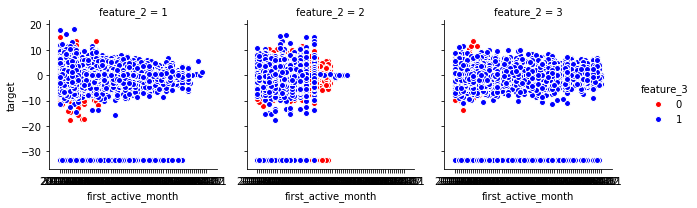

In [125]:
#scatter plot
#modify the graph above by assigning each species an individual color
g = sns.FacetGrid(train ,hue = "feature_3", col = "feature_2", margin_titles = True,
                 palette = {1:"blue", 0:"red"})
g = g.map(plt.scatter, "first_active_month", "target", edgecolor = "w").add_legend();

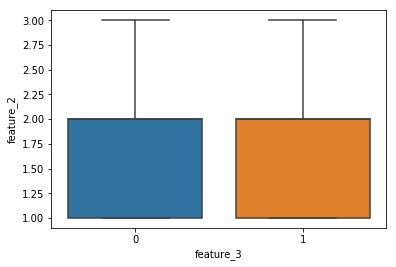

In [126]:
#box
sns.boxplot(x = "feature_3", y = "feature_2", data = test)
plt.show()

In [8]:
def cal_time(x):
    if isinstance(x['first_active_month'],str):
        d1 = datetime.datetime.strptime(x['first_active_month'],'%Y-%m')
        d2 = datetime.datetime.strptime('2019-02','%Y-%m')
        delta = d2 - d1
    else:
        return float('nan')
    
    return int(delta.days/30)

In [9]:
train['time'] = train.apply(cal_time,axis=1)

In [10]:
train['time'].head()

0    20
1    25
2    30
3    17
4    15
Name: time, dtype: int64

In [11]:
test['time'] = test.apply(cal_time,axis=1)

In [12]:
test['time'].median()

22.0

In [13]:
null_columns=test.columns[test.isnull().any()]
test[test.isnull().any(axis=1)][null_columns]

,first_active_month,time
11578,NaN,NaN


In [14]:
test.loc[11578,'time'] = 22

# History_merchant_transactions

In [15]:
ht = pd.read_csv('dataset/all/input/historical_transactions.csv')

In [16]:
ht.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [17]:
ht.merchant_id.value_counts(dropna=False)

M_ID_00a6ca8a8a    1115097
M_ID_e5374dabc0     428619
M_ID_9139332ccc     361385
M_ID_50f575c681     183894
M_ID_fc7d7969c3     177040
M_ID_5ba019a379     170935
NaN                 138481
M_ID_f86439cec0     110341
M_ID_1f4773aa76     106476
M_ID_86be58d7e0      97259
M_ID_98b342c0e3      93394
M_ID_d855771cd9      84377
M_ID_6f274b9340      81072
M_ID_cd2c0b07e9      80179
M_ID_57df19bf28      76750
M_ID_b9dcf28cb9      75487
M_ID_b98db225f5      70384
M_ID_445742726b      68499
M_ID_2637773dd2      66836
M_ID_82a30d9203      65853
M_ID_3111c6df35      52427
M_ID_940fb4498f      51522
M_ID_c03b62d83d      50828
M_ID_820c7b73c8      47404
M_ID_b5b80addf5      45520
M_ID_a9d91682ad      43922
M_ID_7c5e93af2f      42122
M_ID_48257bb851      41150
M_ID_deb43ff012      40878
M_ID_1ac6bbc867      39678
                    ...   
M_ID_0342b6321d          1
M_ID_ab70a5da72          1
M_ID_7544a2a9f0          1
M_ID_3a3a0e2598          1
M_ID_e7c535f2f7          1
M_ID_478e35e871          1
M

In [18]:
ht.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [19]:
ht['authorized_flag'] = ht.authorized_flag.map({'Y':1,'N':0})
ht['category_1'] = ht.category_1.map({'Y':1,'N':0})
ht['category_2'] = ht['category_2'].fillna(0)
ht['category_3'] = ht.category_3.map({'A':0,'B':1,'C':2})
ht['category_3'] = ht['category_3'].fillna(3)
ht = pd.get_dummies(ht,columns = ['category_2','category_3'])

In [20]:
ht.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,category_2_0.0,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_0.0,category_3_1.0,category_3_2.0,category_3_3.0
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,...,0,1,0,0,0,0,1,0,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,...,0,1,0,0,0,0,1,0,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,...,0,1,0,0,0,0,1,0,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,...,0,1,0,0,0,0,1,0,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,...,0,1,0,0,0,0,1,0,0,0


In [21]:
scaler = MinMaxScaler(copy = True, feature_range=(0,1))
scaler.fit(np.array(ht['purchase_amount']).reshape(-1,1))
ht['purchase_amount'] = scaler.transform(np.array(ht['purchase_amount']).reshape(-1,1))

In [22]:
ht.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,category_2_0.0,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_0.0,category_3_1.0,category_3_2.0,category_3_3.0
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,7.250001e-09,2017-06-25 15:33:07,...,0,1,0,0,0,0,1,0,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,2.292501e-09,2017-07-15 12:10:45,...,0,1,0,0,0,0,1,0,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,4.412501e-09,2017-08-09 22:04:29,...,0,1,0,0,0,0,1,0,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,1.922500e-09,2017-09-02 10:06:26,...,0,1,0,0,0,0,1,0,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,4.000000e-09,2017-03-10 01:14:19,...,0,1,0,0,0,0,1,0,0,0


In [23]:
def feature_eng11(data,prefix):
    data['purchase_date'] = pd.to_datetime(data['purchase_date'])
    data['year'] = data['purchase_date'].dt.year
    data['weekofyear'] = data['purchase_date'].dt.weekofyear
    data['purchase_month'] = data['purchase_date'].dt.month
    data['dayofweek'] = data['purchase_date'].dt.dayofweek
    data['weekend'] = (data.purchase_date.dt.weekday >= 5).astype(int)
    data['hour'] = data['purchase_date'].dt.hour
    data['installments'] = data['installments'].astype(int)
    
    data.loc[:,'purchase_date'] = pd.DatetimeIndex(data['purchase_date']).astype(np.int64)*1e-9
    
    agg_func = {
        'authorized_flag':['sum','mean'],
        'category_1':['sum','mean'],
        'category_2_0.0':['sum','mean'],
        'category_2_1.0':['sum','mean'],
        'category_2_2.0':['sum','mean'],
        'category_2_3.0':['sum','mean'],
        'category_2_4.0':['sum','mean'],
        'category_2_5.0':['sum','mean'],
        'category_3_0.0':['sum','mean'],
        'category_3_1.0':['sum','mean'],
        'category_3_2.0':['sum','mean'],
        'category_3_3.0':['sum','mean'],
        'purchase_amount':['sum','mean','max','min','std'],
        'installments':['sum','mean','max','min','std'],
        'purchase_month':['sum','mean','max','min','std'],
        'purchase_date':[np.ptp,'max','min'],
        'month_lag':['min','max','mean','var'],
        'merchant_category_id':['nunique'], #variety
        'state_id':['nunique'],
        'subsector_id':['nunique'],
        'city_id':['nunique'],
    }
   
    agg_trans = data.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace = True)
    
    df = (data.groupby('card_id').size()
         .reset_index(name = '{}transaction_count'.format(prefix)))
    agg_trans = pd.merge(df, agg_trans, on = 'card_id',how = 'left')
    return agg_trans

In [24]:
%%time
history = feature_eng11(ht, prefix = 'hist_')

CPU times: user 1min 33s, sys: 32 s, total: 2min 5s
Wall time: 2min 16s


In [25]:
%%time
temp = ht.groupby(['card_id']).apply(lambda x:x['city_id'].value_counts().idxmax())
temp2 = ht.groupby(['card_id']).apply(lambda x:x['state_id'].value_counts().idxmax())
temp3 = ht.groupby(['card_id']).apply(lambda x:x['subsector_id'].value_counts().idxmax())
abc = pd.DataFrame(temp,columns = ['hist_city_id'])
history_ = pd.merge(history,abc, on = 'card_id',how = 'left')
abc = pd.DataFrame(temp2,columns = ['hist_state_id'])
history_ = pd.merge(history_,abc, on = 'card_id',how = 'left')
abc = pd.DataFrame(temp3,columns = ['hist_sub_id'])
history_ = pd.merge(history_,abc, on = 'card_id',how = 'left')

CPU times: user 9min 11s, sys: 45.5 s, total: 9min 57s
Wall time: 10min 22s


In [26]:
import gc
gc.collect()
train = pd.merge(train, history_,on = 'card_id',how = 'left')
test = pd.merge(test,history_,on = 'card_id',how = 'left')
del history_
gc.collect()
del ht

# New_merchant_transactions

In [27]:
nmt = pd.read_csv('dataset/all/input/new_merchant_transactions.csv')

In [28]:
nmt.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [29]:
nmt['authorized_flag'] = nmt.authorized_flag.map({'Y':1,'N':0})
nmt['category_1'] = nmt.category_1.map({'Y':1,'N':0})
nmt['category_2'] = nmt['category_2'].fillna(0)
nmt['category_3'] = nmt.category_3.map({'A':0,'B':1,'C':2,'nan':3})
nmt = pd.get_dummies(nmt,columns = ['category_2','category_3'])

In [30]:
scaler = MinMaxScaler(copy = True, feature_range=(0,1))
scaler.fit(np.array(nmt['purchase_amount']).reshape(-1,1))
nmt['purchase_amount'] = scaler.transform(np.array(nmt['purchase_amount']).reshape(-1,1))

In [31]:
def feature_eng12(data,prefix):
    
    data['purchase_date'] = pd.to_datetime(nmt['purchase_date'])
    data['year'] = data['purchase_date'].dt.year
    data['weekofyear'] = data['purchase_date'].dt.weekofyear
    data['purchase_month'] = data['purchase_date'].dt.month
    data['dayofweek'] = data['purchase_date'].dt.dayofweek
    data['weekend'] = (data.purchase_date.dt.weekday >= 5).astype(int)
    data['hour'] = data['purchase_date'].dt.hour
    data['installments'] = data['installments'].astype(int)   
    data.loc[:,'purchase_date'] = pd.DatetimeIndex(data['purchase_date']).astype(np.int64)*1e-9

    agg_func = {
        'authorized_flag':['sum','mean'],
        'category_1':['sum','mean'],
        'category_2_0.0':['sum','mean'],
        'category_2_1.0':['sum','mean'],
        'category_2_2.0':['sum','mean'],
        'category_2_3.0':['sum','mean'],
        'category_2_4.0':['sum','mean'],
        'category_2_5.0':['sum','mean'],
        'category_3_0.0':['sum','mean'],
        'category_3_1.0':['sum','mean'],
        'category_3_2.0':['sum','mean'],
     
        'purchase_amount':['sum','mean','max','min','std'],
        'installments':['sum','mean','max','min','std'],
        'purchase_month':['sum','mean','max','min','std'],
        'purchase_date':[np.ptp,'max','min'],
        'month_lag':['min','max','mean','var'],
        'merchant_category_id':['nunique'], #variety
        'state_id':['nunique'],
        'subsector_id':['nunique'],
        'city_id':['nunique'],
    }
   
    agg_trans = data.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace = True)
    
    df = (data.groupby('card_id').size()
         .reset_index(name = '{}transaction_count'.format(prefix)))
    agg_trans = pd.merge(df, agg_trans, on = 'card_id',how = 'left')
    return agg_trans

In [32]:
%%time
gc.collect()
new = feature_eng12(nmt,prefix = 'new_')
gc.collect()

CPU times: user 33 s, sys: 1.35 s, total: 34.4 s
Wall time: 34.5 s


In [33]:
temp = nmt.groupby(['card_id']).apply(lambda x:x['city_id'].value_counts().idxmax())
temp2 = nmt.groupby(['card_id']).apply(lambda x:x['state_id'].value_counts().idxmax())
temp3 = nmt.groupby(['card_id']).apply(lambda x:x['subsector_id'].value_counts().idxmax())
abc = pd.DataFrame(temp,columns=['new_city_id'])
new_ = pd.merge(new, abc, on='card_id', how='left')
abc = pd.DataFrame(temp2,columns=['new_state_id'])
new_ = pd.merge(new_, abc, on='card_id', how='left')
abc = pd.DataFrame(temp3,columns=['new_sub_id'])
new_ = pd.merge(new_, abc, on='card_id', how='left')

In [34]:
gc.collect()
train = pd.merge(train, new_,on = 'card_id',how = 'left')
test = pd.merge(test,new_,on = 'card_id',how = 'left')
del new_
gc.collect()
del nmt

In [35]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'time', 'hist_transaction_count', 'hist_authorized_flag_sum',
       'hist_authorized_flag_mean',
       ...
       'new_month_lag_max', 'new_month_lag_mean', 'new_month_lag_var',
       'new_merchant_category_id_nunique', 'new_state_id_nunique',
       'new_subsector_id_nunique', 'new_city_id_nunique', 'new_city_id',
       'new_state_id', 'new_sub_id'],
      dtype='object', length=113)

In [36]:
train['lifetime'] = train['new_purchase_date_max'] - train['hist_purchase_date_min']
train['Purchase_rate'] = (train['hist_transaction_count'] + train['new_transaction_count']) / train['lifetime']
test['lifetime'] = test['new_purchase_date_max'] - test['hist_purchase_date_min']
test['Purchase_rate'] = (test['hist_transaction_count'] + test['new_transaction_count']) / test['lifetime']

In [37]:
len(train.columns)

115

# Build Model

In [38]:
y = train['target']

In [39]:
for col in ['first_active_month','card_id','target']:
    if col in train.columns:
        train.drop([col],axis = 1, inplace = True)
    if col in test.columns:
        test.drop([col],axis = 1, inplace = True)

In [40]:
X_train = train
X_test = test

In [41]:
len(X_test.columns)

112

In [42]:
n_fold = 5
kfolds = KFold(n_splits = n_fold, shuffle = True, random_state = 11)

In [43]:
sfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2333)

In [44]:
def train_model(X = X_train, X_test = X_test, y = y, params = None, folds = kfolds, model_type = 'lgb', plot_feature_importance = False):
    #use sfolds and change
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
           
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration = model.best_iteration_)
            
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred
        if model_type =='lgb':
            #feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis = 0)
            
    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std{1:4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by = "importance", ascending = False)[:50].index
            
            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            
            plt.figure(figsize = (16,12));
            sns.barplot(x = "importance", y = 'feature', data = best_features.sort_values(by = "importance",ascending = False));
            plt.title('LGB Features (avg over folds)');
            
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [45]:
params ={'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 15,
         'learning_rate':0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,
}

Fold 0 started at Sat Jan 26 10:25:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[436]	training's rmse: 3.3822	valid_1's rmse: 3.71009
Fold 1 started at Sat Jan 26 10:26:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[562]	training's rmse: 3.34117	valid_1's rmse: 3.64124
Fold 2 started at Sat Jan 26 10:26:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[525]	training's rmse: 3.34918	valid_1's rmse: 3.68186
Fold 3 started at Sat Jan 26 10:26:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 3.39472	valid_1's rmse: 3.66714
Fold 4 started at Sat Jan 26 10:27:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[498]	training's rmse: 3.37479	valid_1's rmse: 3.62517
CV mean score: 3.6651

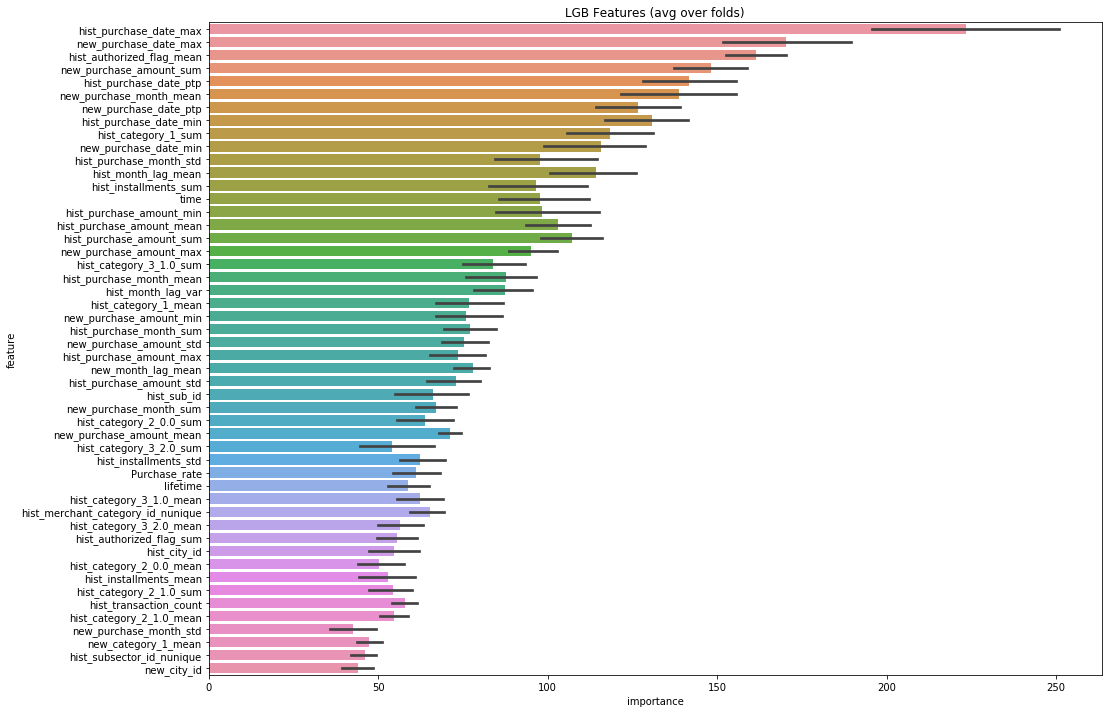

In [46]:
oof_lgb, prediction_lgb, feature_importance = train_model(params = params, model_type = 'lgb', plot_feature_importance = True)

In [76]:
sample_submission = pd.read_csv('dataset/all/output/sample_submission0125.csv')
sample_submission['target'] = prediction_lgb
sample_submission.to_csv('dataset/all/output/lgb.csv', index = False)

In [75]:
sample_submission['target'].describe()

count    123623.000000
mean         -0.392047
std           1.163743
min         -18.508661
25%          -0.648206
50%          -0.200616
75%           0.166906
max           2.946499
Name: target, dtype: float64

In [49]:
train2 = pd.read_csv('dataset/all/input/train.csv')
test2 = pd.read_csv('dataset/all/input/test.csv')

In [50]:
train['outliers'] = np.where(train2['target']<-30,1,0)
train['target'] = train2['target']
train['card_id'] = train2['card_id']
train['first_active_month'] = train2['first_active_month']
test['card_id'] = test2['card_id']
test['first_active_month'] = test2['first_active_month']
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

# Training model for data without outliers

In [51]:
param1 = {'objective':'regression',
          'num_leaves':31,
          'min_data_in_leaf':25,
          'max_depth':7,
          'learning_rate':0.01,
          'lambda_11':0.13,
          "boosting":"gbdt",
          "feature_fraction":0.85,
          'bagging_freq':8,
          "bagging_fraction":0.9,
          "metric":'rmse',
          "verbosity":-1,
          "random_state":2333}

In [52]:
df_train = train[train['outliers'] == 0]
target = df_train['target']
del df_train['target']
features = [c for c in df_train.columns if c not in['card_id','first_active_month','outliers']]
categorical_feats = [c for c in features if 'feature_' in c]
df_test = test

In [53]:
def model_mix1(df_train,features,categorical_feats,df_test):
    sfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2333)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(sfolds.split(df_train,df_train['outliers'].values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label = target.iloc[trn_idx])
        val_data = lgb.Dataset(df_train.iloc[val_idx][features],label = target.iloc[val_idx])
        num_round = 10000
        clf = lgb.train(param1, trn_data, num_round, valid_sets = 
                       [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
        predictions += clf.predict(df_test[features], num_iteration = clf.best_iteration) / sfolds.n_splits
    return(predictions)

In [54]:
%%time
pred_no_outliers = model_mix1(df_train, features, categorical_feats, df_test)

fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.60332	valid_1's rmse: 1.61492
[200]	training's rmse: 1.57289	valid_1's rmse: 1.58882
[300]	training's rmse: 1.55891	valid_1's rmse: 1.5788
[400]	training's rmse: 1.54986	valid_1's rmse: 1.57353
[500]	training's rmse: 1.543	valid_1's rmse: 1.57053
[600]	training's rmse: 1.53746	valid_1's rmse: 1.56837
[700]	training's rmse: 1.53274	valid_1's rmse: 1.56713
[800]	training's rmse: 1.52841	valid_1's rmse: 1.56617
[900]	training's rmse: 1.52443	valid_1's rmse: 1.56544
[1000]	training's rmse: 1.52074	valid_1's rmse: 1.56504
[1100]	training's rmse: 1.51703	valid_1's rmse: 1.56451
[1200]	training's rmse: 1.51349	valid_1's rmse: 1.5642
[1300]	training's rmse: 1.51016	valid_1's rmse: 1.56402
[1400]	training's rmse: 1.50715	valid_1's rmse: 1.56387
[1500]	training's rmse: 1.50395	valid_1's rmse: 1.56374
[1600]	training's rmse: 1.50088	valid_1's rmse: 1.56355
[1700]	training's rmse: 1.49773	valid_1's rmse:

In [55]:
model_without_outliers = pd.DataFrame({"card_id":df_test["card_id"].values})
model_without_outliers["target"] = pred_no_outliers

# Training Model For Outliers classification

In [56]:
df_train2 = train
target2 = train['outliers']
del df_train2['outliers']
del df_train2['target']
df_train2.shape

(201917, 114)

In [57]:
features2 = [c for c in df_train2.columns if c not in ['card_id', 'first_active_month']]
categorical_feats2 = [c for c in features if 'feature_' in c]

In [58]:
param2 = {'num_leaves': 31,
         'min_data_in_leaf': 30,
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_11": 0.1,
         "verbosity": -1,
         "random_state":2333}

In [59]:
def model_mix2(df_train, features, categorical_feats, df_test, target):
    folds = KFold(n_splits = 5, shuffle = True, random_state = 15)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    
    start = time.time()
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label = target.iloc[trn_idx], categorical_feature = categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][features], label = target.iloc[val_idx], categorical_feature = categorical_feats)
        
        num_round = 10000
        clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
        
        predictions += clf.predict(df_test[features], num_iteration = clf.best_iteration)
    return(predictions, clf)

In [60]:
%%time
pred_outliers, clf_outliers = model_mix2(df_train2, features2, categorical_feats2, df_test, target2)

fold n°0


/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0450986	valid_1's binary_logloss: 0.0478928
[200]	training's binary_logloss: 0.0450984	valid_1's binary_logloss: 0.0479082
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.0450066	valid_1's binary_logloss: 0.0477504
fold n°1


/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0454943	valid_1's binary_logloss: 0.046341
[200]	training's binary_logloss: 0.0455018	valid_1's binary_logloss: 0.0463319
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0454988	valid_1's binary_logloss: 0.0462547
fold n°2


/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0456019	valid_1's binary_logloss: 0.0448419
[200]	training's binary_logloss: 0.0456412	valid_1's binary_logloss: 0.0448846
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.0455377	valid_1's binary_logloss: 0.044807
fold n°3


/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0442611	valid_1's binary_logloss: 0.0503351
[200]	training's binary_logloss: 0.044273	valid_1's binary_logloss: 0.0503352
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.0441957	valid_1's binary_logloss: 0.0502931
fold n°4


/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/shutingchen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0454159	valid_1's binary_logloss: 0.0458092
[200]	training's binary_logloss: 0.045416	valid_1's binary_logloss: 0.0457952
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.0453597	valid_1's binary_logloss: 0.0457174
CPU times: user 3min 42s, sys: 20.6 s, total: 4min 2s
Wall time: 37.8 s


In [61]:
train_pred = clf_outliers.predict(df_train2[features2], num_iteration = clf_outliers.best_iteration)

In [62]:
threshold = 0.4
train_pred[train_pred < threshold] = 0
train_pred[train_pred >= threshold] = 1

In [63]:
confusion_matrix(target2, train_pred)

array([[199710,      0],
       [  2207,      0]])

In [64]:
df_outlier_prob = pd.DataFrame({"card_id":df_test["card_id"].values})
df_outlier_prob["target"] = pred_outliers
df_outlier_prob.head()

,card_id,target
0,C_ID_0ab67a22ab,0.251711
1,C_ID_130fd0cbdd,0.009044
2,C_ID_b709037bc5,0.033288
3,C_ID_d27d835a9f,0.009044
4,C_ID_2b5e3df5c2,0.009044


# Combine

In [65]:
#In case missing some predictable outlier, we choose top 25000 with highest outliers likelyhood
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by = 'target', ascending = False).head(25000)['card_id'])

In [77]:
best_submission = pd.read_csv('dataset/all/output/lgb.csv')

In [79]:
most_likely_liers = best_submission.merge(outlier_id, how = 'right')
best_submission.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.768613
1,C_ID_130fd0cbdd,-0.274785
2,C_ID_b709037bc5,-0.728279
3,C_ID_d27d835a9f,-0.251455
4,C_ID_2b5e3df5c2,-1.158492


In [80]:
#%%time
model_without_outliers.loc[model_without_outliers["card_id"].isin(outlier_id["card_id"].values), "target"] = best_submission[best_submission["card_id"].isin(outlier_id["card_id"].values)]["target"]

In [94]:
model_without_outliers.to_csv("dataset/all/output/combining_submission.csv", index=False)

In [95]:
model_without_outliers.shape

(123623, 2)

In [88]:
submission1 = pd.read_csv('dataset/all/output/combining_submission3.csv')

In [91]:
submission1.shape

(123623, 2)